# Categorização de falhas dos equipmentos a partir das variáveis Preset_1 e Preset_2.

OBS: A intensão é de que este notebook contenha em sua maior parte, apenas os códigos pertinentes a construção do modelo XGBoost que irá categorizar as falha.

Este notebook conterá uma pequena análise exploratória, contrução com treino e teste do modelo de machine learning, bem como o salvamento do modelo criado.

In [ ]:
# Importação dos pacotes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df = pd.read_excel('O_G_Equipment_Data.xlsx')
#df = df.drop(columns={'Unnamed: 0'})
df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


In [ ]:
df.shape

(800, 10)

## Análise exploratória, sobre a relação da facha com o tipo de preset configurado durante a aparição da falha.

##### OBS: O objetivo é desenvolver um modelo de machine learnning que faça inferência utilizando apenas os atributos determinados, logo é interessante, fazer uma pequena análise exploratória da contagem em que cada uma das variáveis contidas nos preset 1 e 2 estava configurada durante as falhas observadas.

In [ ]:
# Codificação da feature Fail 

labels = df['Fail'].astype('category').cat.categories.tolist()
replace_Fail = {'Fail': {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print(replace_Fail)

{'Fail': {False: 1, True: 2}}


In [ ]:
# Substituindo os valores tranformados.

df.replace(replace_Fail, inplace=True)

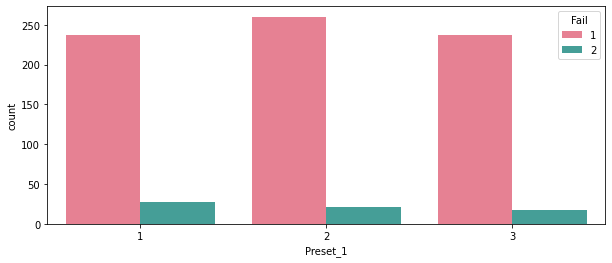

In [ ]:
# Contagem dos valores do atributo Preset_1.
plt.figure(figsize=(10,4))
sns.countplot(data=df, x=('Preset_1'), hue='Fail', palette='husl')
plt.show()

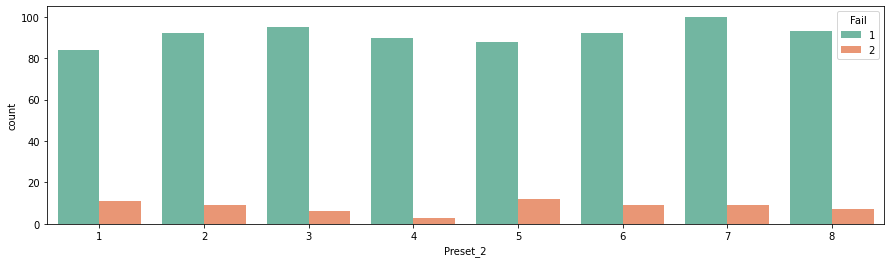

In [ ]:
# Contagem dos valores do atributo Preset_2.
plt.figure(figsize=(15,4))
sns.countplot(data=df, x='Preset_2', hue='Fail', palette='Set2')
plt.show()

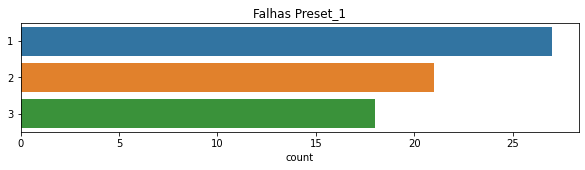

In [ ]:
'''Código utilizado para saber a proporção de FALHAS por Preset_2.'''

p1 = df[df['Fail']==2]['Preset_1'].values

plt.subplots(figsize= (10,2))

sns.countplot(y=p1)
plt.title("Falhas Preset_1")
plt.show()

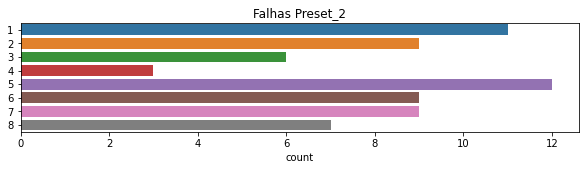

In [ ]:
'''Código utilizado para saber a proporção de FALHAS por Preset_2.'''

p2 = df[df['Fail']==2]['Preset_2'].values

plt.subplots(figsize= (10,2))

sns.countplot(y=p2)
plt.title("Falhas Preset_2")
plt.show()

## **Machine Learning - Preset_1 & Preset_2**

### A partir desse ponto será criado um modelo de Gradient Boost Tree, para verificar a possibilidade de categorizar, ordenar as falhas por "grau de intensidade"

#### Houve a tentativa de desenvolver o modelo de machine após utilizar o recurso **One Hot Encoder** para que os atributos Preset 1 e 2, porém os número de estivativas de quantidade de árvores que seriam formadas para construção do modelo, ficava sempre abaixo de zero, assim, gerando um erro, logo, os dados ficam muito dispersos e o modelo não consegue entender uma relação destes com as falhas apresentadas pelo equipamento. Então a melhor decisão é utilizar os dois atributos Preset 1 & 2 sem codificá-los. 

## Separação do Treino e Teste 

OBS: Dataset Contendo apenas os Atributos: Preset_1, Preset_2, Fail

In [ ]:
data = df.copy()
data = data.drop(columns={'Cycle','Temperature', 'Pressure',
       'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency'})
data.head()

,Preset_1,Preset_2,Fail
0,3,6,1
1,2,4,1
2,2,1,1
3,2,3,1
4,2,5,1


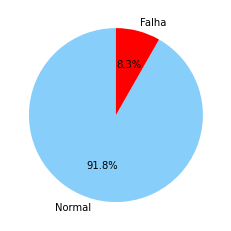

In [ ]:
"""Esse código será a base para comparação com a proporção criada após separação
da base de teste e base de treino."""

df_t = pd.DataFrame(data.Fail.value_counts())

status = ['Normal', 'Falha']

df_t.insert(loc=1,column='status', value=status)

labels = df_t.status
colors = ['lightskyblue', 'red']
plt.pie(df_t['Fail'], labels= labels, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

In [ ]:
"""Separação em TREINO e TESTE"""

seed = 173 # certifica que os dados serão divididos em com o label para teste e treino na mesma proporção.

from sklearn.model_selection import train_test_split

X = data.loc[:, data.columns != 'Fail']    # ENTRADA, Esse trecho de código remove a coluna a ser definida pelo modelo.
Y = data.Fail                              # SAÍDA


"""É nesse trecho de código que é feita a divisão da base de treino e  teste para se fazer a validação do modelo treinado,
e que posteriormente será salvo e dedicado em uma pasta específica para que esteja pronto para produção."""

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=seed) 

print('shape input de treino', X_train.shape)
print('shape input de teste', X_test.shape)
print('shape output de treino', Y_train.shape)
print('shape output de teste', Y_test.shape)

shape input de treino (640, 2)
shape input de teste (160, 2)
shape output de treino (640,)
shape output de teste (160,)


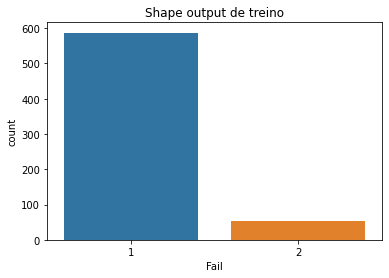

1    587
2     53
Name: Fail, dtype: int64

In [ ]:
''' OBS: Verificando as proporções dos valores contido no atributo Fail, após a 
utilização de uma seed considerada ideal para criação do modelo de ML. '''

#TREINO

sns.countplot(x=Y_train)
plt.title("Shape output de treino")
plt.show()

Y_train.value_counts()

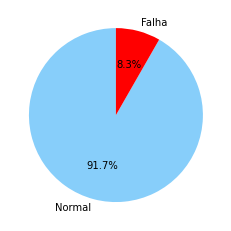

In [ ]:
"""Verificando se a seed utilizada na separação da base de treino e teste está
na proporção ideal para o modelo"""

df_train = pd.DataFrame(Y_train.value_counts())

status = ['Normal', 'Falha']

df_train.insert(loc=1,column='status', value=status)

labels = df_train.status
colors = ['lightskyblue', 'red']
plt.pie(df_train['Fail'], labels= labels, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

#### É possível verificar enque a proporção do atributo Fail está bastante similar ao conjunto original de dados, o que nos garante uma boa margem de acurácia durante a criação do modelo classificador.

O mesmos será feito para a base de teste.

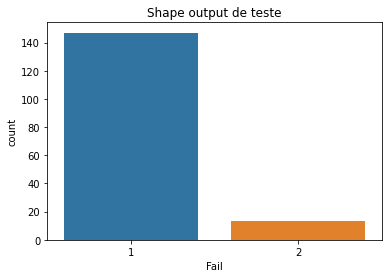

1    147
2     13
Name: Fail, dtype: int64

In [ ]:
# TESTE

sns.countplot(x=Y_test)
plt.title("Shape output de teste")
plt.show()

Y_test.value_counts()

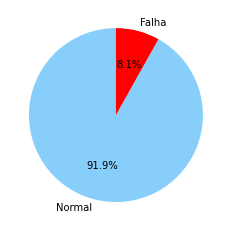

In [ ]:
df_test = pd.DataFrame(Y_test.value_counts())

status = ['Normal', 'Falha']

df_test.insert(loc=1,column='status', value=status)

labels = df_test.status
colors = ['lightskyblue', 'red']
plt.pie(df_test['Fail'], labels= labels, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

## GBT

In [ ]:
''' Importando as bibliotecas necessárias para criação do modelo de ML'''

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
'''Construindo o modelo de ML com a função do SKLearn.

Todas a modificações e aprimorações no modelo desem ser feitas nesse trecho
de código, utilizando a biblioteca referente para aprimorar as métricas
do modelo. '''

regressor = GradientBoostingRegressor(
    max_depth=2,       # referente ao número de "folhas" por árvore.
    n_estimators=2,    # referente ao quantidade de árvores por conjunto
    learning_rate=1.0  # hiperparametriza (escolhe os mehores valores) em um range determinado.
)
regressor.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=2)

In [ ]:
''' Esse código irá medir a validação de cada erro (média quadrática do erro) encontrado 
durante a construção do modelo e a partir dessa medição encontrar o número ótimo de árvores 
para que o modelo esteja o mais preciso possível.'''

errors = [mean_squared_error(Y_test, Y_pred) for Y_pred in regressor.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)

In [ ]:
# Modelo sendo reconstruindo com os melhores valores selecionados após os erros serem "corrigidos".

best_regressor = GradientBoostingRegressor(
    max_depth=2,
    n_estimators=best_n_estimators,
    learning_rate=1.0
)
best_regressor.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=1)

In [ ]:
'''Verificando a média absoluta de erros que o modelo gerou ao tentar classificar
os labels definidos'''

Y_pred = best_regressor.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

0.15036775173260106

### NORMALIZAÇÃO

In [ ]:
'''Utilizando uma das técnicas de normalização para proporcionar uma otimização
extra no modelo criado.'''

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Verificando o quanto de melhora foi gerada após a normalização.

Y_pred = best_regressor.predict(X_test)
mean_absolute_error(Y_test, Y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"


0.1737645348837209

In [ ]:
import pickle
pickle.dump(best_regressor, open('model_GBT.sav', 'wb'))